In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torchvision.models import resnet18,ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision.transforms.transforms import random
from sklearn import metrics

In [ ]:
transform_train = transforms.Compose(
    [
     transforms.Resize(size=(112,112)),
     transforms.RandomHorizontalFlip(p=0.25),
     transforms.RandomVerticalFlip(p=.25),
     transforms.RandomRotation(degrees= 30 if random.random()<0.25 else 0 ),
    #  transforms.RandomApply(torch.nn.ModuleList([transforms.Pad(padding=int(random.random()*10))]),p=0.25),
    #  transforms.RandomResizedCrop(size=32,scale=(0.8,1),ratio=(0.75,1.25)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
transform_test = transforms.Compose(
    [
     transforms.Resize(size=(112,112)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Note
# 1.for each part please set the proper batch size as follow (read the comment in front of batch_size)

# 2.run all cells  before the first section then you can run each section Separately

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
num_epochs=40
batch_size =256 # proper batch size is 1024 for teacher training part one  ********  512  for part 2 and 3  **********  256 part 4 
criterion = nn.CrossEntropyLoss()

# split train  and test
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, validation_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,sampler=train_sampler)



validation_sampler = SubsetRandomSampler(validation_indices)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                sampler=validation_sampler)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

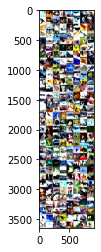

ship  dog   truck dog   truck plane plane horse bird  deer  truck deer  plane car   bird  bird  frog  ship  dog   truck dog   car   horse cat   frog  frog  bird  ship  ship  frog  plane plane bird  plane ship  dog   deer  ship  dog   car   dog   car   dog   bird  frog  deer  dog   plane frog  truck dog   bird  ship  dog   deer  car   truck horse car   ship  plane plane frog  cat   dog   frog  horse horse plane deer  horse car   truck plane deer  dog   ship  ship  plane frog  truck bird  cat   horse frog  plane truck ship  truck truck frog  cat   deer  deer  dog   ship  ship  plane ship  deer  plane frog  truck cat   plane dog   ship  ship  bird  car   truck dog   truck horse deer  car   dog   truck truck deer  cat   bird  bird  deer  ship  car   plane car   cat   deer  cat   truck dog   deer  ship  plane plane deer  car   deer  deer  ship  deer  deer  cat   cat   truck car   cat   dog   deer  cat   plane bird  truck horse horse plane ship  car   truck ship  cat   bird  ship  plane dog 

In [ ]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

def test_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    true_label=[]
    predicted_label=[]
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
        true_label.extend(labels.detach().cpu())
        predicted_label.extend(predictions.detach().cpu())

    return valid_loss,val_correct,true_label,predicted_label

# Part 1 Train on Resnet50

In [ ]:


# Old weights with accuracy 76.130%
#resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
#resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
#resnet50(weights=ResNet50_Weights.DEFAULT)

# Strings are also supported
ORG_Model=resnet50(weights="IMAGENET1K_V2")

# No weights - random initialization
#resnet50(weights=None)

# ORG_Model.fc=nn.Sequential(nn.Linear(2048,1024),nn.ReLU(),nn.Linear(1024,10))


ORG_Model.fc=nn.Linear(2048,10)
# nn.init.xavier_normal_(ORG_Model.fc.weight,gain=1)
Frezzed_Model=ORG_Model.requires_grad_(False)
Frezzed_Model.fc=Frezzed_Model.fc.requires_grad_(True)
Frezzed_Model=Frezzed_Model.cuda()

Train

In [ ]:

history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
min_loss_validation=9999


model = Frezzed_Model

# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,weight_decay=0)
# optimizer = optim.Adam(Frezzed_Model.parameters(),lr=1e-4,weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=1e-2,weight_decay=1e-5)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=num_epochs,eta_min=1e-5,last_epoch=-1,verbose=True)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.95,last_epoch=-1,verbose=True)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[5,10,15],gamma=0.1,verbose=True)

  


for epoch in range(num_epochs):
  
  train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
  val_loss, val_correct=valid_epoch(model,device,val_loader,criterion)

  train_loss = train_loss / len(train_loader.sampler)
  train_acc = train_correct / len(train_loader.sampler) * 100
  val_loss = val_loss / len(val_loader.sampler)
  val_acc = val_correct / len(val_loader.sampler) * 100
  scheduler.step()
  print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        val_loss,
                                                                                                        train_acc,
                                                                                                        val_acc))
  if val_loss<min_loss_validation:
      best_model_ResNet50=model
      min_loss_validation=val_loss
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  history['train_acc'].append(train_acc)
  history['val_acc'].append(val_acc)  

PATH = '/content/drive/MyDrive/HW3_Q2/TeacherModel'
torch.save(best_model_ResNet50.state_dict(), PATH)


In [ ]:
ORG_Model=resnet50(weights="IMAGENET1K_V2").requires_grad_(False)
ORG_Model.fc=nn.Linear(2048,10)
PATH = '/content/drive/MyDrive/HW3_Q2/TeacherModel'
ORG_Model.load_state_dict((torch.load(PATH)))
best_model_ResNet50=ORG_Model.cuda()
# test 
test_loss, test_correct,true_label,predicted_label=test_epoch(best_model_ResNet50,device,testloader,criterion) # best_model_ResNet50
# Print the confusion matrix
print(metrics.confusion_matrix(true_label, predicted_label))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_label, predicted_label, digits=3))
print(f"Best Model Accuracy on test Data is {test_correct/len(testloader.sampler) * 100}")
print(f"Model Loss on test data is {test_loss/ len(testloader.sampler)}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[[851  14  21   5  10   0   4   8  67  20]
 [ 12 887   2   5   1   0   3   0  19  71]
 [ 23   3 837  35  40  14  32  11   5   0]
 [ 10   4  29 744  19 122  37  19   6  10]
 [  4   3  42  42 787  23  23  66   6   4]
 [  2   2  13  96  21 833  10  22   0   1]
 [  4   3  18  20  25  13 902   5   5   5]
 [  8   3  13  21  58  24   4 859   5   5]
 [ 40  17   9   6   5   1   3   4 891  24]
 [ 13  65   0   6   1   0   0   1  15 899]]
              precision    recall  f1-score   support

           0      0.880     0.851     0.865      1000
           1      0.886     0.887     0.887      1000
           2      0.851     0.837     0.844      1000
           3      0.759     0.744     0.752      1000
           4      0.814     0.787     0.800      1000
           5      0.809     0.833     0.821      1000
           6      0.886     0.902     0.894      1000
           7      0.863     0.859     0.861      1000
           8      0.874     0.891     0.883      1000
           9      0.865     

# Part Use distilation Model ResNet18 as student on ResNet as Teacher

In [ ]:
class Knowledge_Distillation(nn.Module):
  def __init__(self,PATH):
    super(Knowledge_Distillation,self).__init__()
    ORG_Model_Resnet50=resnet50(weights="IMAGENET1K_V2")
    ORG_Model_Resnet50.fc=nn.Linear(2048,10)
    ORG_Model_Resnet50.load_state_dict(torch.load(PATH))
    
    ORG_Model_Resnet18=resnet18(weights=ResNet18_Weights.DEFAULT)
    ORG_Model_Resnet18.fc=nn.Linear(512,10)

    
    self.Teacher_Model=ORG_Model_Resnet50.requires_grad_(False).cuda()

    self.Student_Model=ORG_Model_Resnet18.requires_grad_(True).cuda()

  def forward(self,x):
    student_logits = self.Student_Model(x)
    teacher_logits = self.Teacher_Model(x)

    return teacher_logits,student_logits

softmax = nn.Softmax(dim=1)

def loss_KD(teacher_logits,student_logits,labels,alpha,T):
  
  # tlogits=teacher_logits.detach().cpu()
  # slogits=student_logits.detach().cpu()
  Loss1 = (1-alpha)*criterion(student_logits,labels)
  # print(Loss1.device)
  Loss2 = (alpha*(T**2))*criterion(student_logits/T,softmax(teacher_logits/T))
  # print(Loss2.device)
  total_loss = Loss1 + Loss2
  return total_loss,Loss1,Loss2


In [ ]:
softmax = nn.Softmax(dim=1)

def train_epoch_1(model,device,dataloader,loss_fn,optimizer,T,alpha):
    train_loss,train_correct=0.0,0
    train_Loss1,train_Loss2=0.0,0.0
    model.train()
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        optimizer.zero_grad()
        teacher_logits,student_logits = model(images)
        total_loss,Loss1,Loss2 = loss_fn(teacher_logits=teacher_logits,student_logits=student_logits,labels=labels,alpha=alpha,T=T)


        # Loss1 = (1-alpha)*loss_fn(student_logits,labels)
        # Loss2 = (alpha*(T**2))*loss_fn(student_logits,softmax(teacher_logits/T))
        # total_loss = Loss1 + Loss2



        total_loss.backward()
        optimizer.step()
        train_loss+= total_loss.item() * images.size(0)
        train_Loss1+= Loss1.item() * images.size(0)
        train_Loss2+= Loss2.item() * images.size(0)
        scores, predictions = torch.max(student_logits.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct,train_Loss1,train_Loss2
  
def valid_epoch_1(model,device,dataloader,loss_fn,T,alpha):
    valid_loss, val_correct = 0.0, 0
    valid_Loss1,valid_Loss2=0.0,0.0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        teacher_logits,student_logits = model(images)
        total_loss,Loss1,Loss2= loss_fn(teacher_logits=teacher_logits,student_logits=student_logits,labels=labels,alpha=alpha,T=T)
        # Loss1 = (1-alpha)*loss_fn(student_logits,labels)
        # Loss2 = (alpha*(T**2))*loss_fn(student_logits,softmax(teacher_logits/T))
        # total_loss = Loss1 + Loss2


        valid_loss+=total_loss.item()*images.size(0)
        valid_Loss1+=Loss1.item()*images.size(0)
        valid_Loss2+=Loss2.item()*images.size(0)
        scores, predictions = torch.max(student_logits.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct,valid_Loss1,valid_Loss2
    
def test_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    true_label=[]
    predicted_label=[]
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
        true_label.extend(labels.detach().cpu())
        predicted_label.extend(predictions.detach().cpu())

    return valid_loss,val_correct,true_label,predicted_label
def test_epoch_1(model,device,dataloader,loss_fn,T,alpha):
    test_loss, test_correct = 0.0, 0
    test_loss1,test_loss2=0.0,0.0
    model.eval()
    true_label=[]
    predicted_label=[]
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        teacher_logits,student_logits = model(images)
        # total_loss,Loss1,Loss2= loss_fn(teacher_logits=teacher_logits,student_logits=student_logits,labels=labels,alpha=alpha,T=T)
        Loss1 = (1-alpha)*loss_fn(student_logits,labels)
        Loss2 = (alpha*(T**2))*loss_fn(student_logits,softmax(teacher_logits/T))
        total_loss = Loss1 + Loss2

        test_loss+=total_loss.item()*images.size(0)
        test_loss1+=Loss1.item()*images.size(0)
        test_loss2+=Loss2.item()*images.size(0)

        scores, predictions = torch.max(student_logits.data,1)
        test_correct+=(predictions == labels).sum().item()
        true_label.extend(labels.detach().cpu())
        predicted_label.extend(predictions.detach().cpu())

    return test_loss,test_correct,true_label,predicted_label,test_loss1,test_loss2


In [ ]:
alpha=0.1
T=15
PATH = '/content/drive/MyDrive/HW3_Q2/TeacherModel'

history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
min_loss_validation=9999


model = Knowledge_Distillation(PATH).cuda()

# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,weight_decay=0)
# optimizer = optim.Adam(Frezzed_Model.parameters(),lr=1e-4,weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=num_epochs,eta_min=1e-5,last_epoch=-1,verbose=True)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.95,last_epoch=-1,verbose=True)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[5],gamma=0.01,verbose=True)

  


for epoch in range(num_epochs):
  
  train_loss, train_correct,train_Loss1,train_Loss2=train_epoch_1(model,device,train_loader,loss_KD,optimizer,T,alpha)
  val_loss, val_correct,valid_Loss1,valid_Loss2=valid_epoch_1(model,device,val_loader,loss_KD,T,alpha)

  train_loss = train_loss / len(train_loader.sampler)
  train_Loss1 = train_Loss1 / len(train_loader.sampler)
  train_Loss2 = train_Loss2 / len(train_loader.sampler)
  train_acc = train_correct / len(train_loader.sampler) * 100

  val_loss = val_loss / len(val_loader.sampler)
  valid_Loss1 = valid_Loss1 / len(val_loader.sampler)
  valid_Loss2 = valid_Loss2 / len(val_loader.sampler)
  val_acc = val_correct / len(val_loader.sampler) * 100
  scheduler.step()

  print("Epoch:{}/{} AVG Training Total Loss:{:.3f} AVG Training Loss1:{:.3f}  AVG Training Loss2:{:.3f} \n \
  AVG Validation total Loss:{:.3f} AVG Validation Loss1:{:.3f} AVG Validation Loss1:{:.3f} \n \
   AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        train_Loss1,
                                                                                                        train_Loss2,
                                                                                                        val_loss,
                                                                                                        valid_Loss1,
                                                                                                        valid_Loss2,
                                                                                                        train_acc,
                                                                                                        val_acc))
  if val_loss<min_loss_validation:
      best_student_model_1=model
      min_loss_validation=val_loss
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  history['train_acc'].append(train_acc)
  history['val_acc'].append(val_acc)  


PATH = '/content/drive/MyDrive/HW3_Q2/best_student_model_1'

torch.save(best_student_model_1.Student_Model.state_dict(), PATH)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9847e-04.
Epoch:1/40 AVG Training Total Loss:51.438 AVG Training Loss1:0.485  AVG Training Loss2:50.953 
   AVG Validation total Loss:51.314 AVG Validation Loss1:0.396 AVG Validation Loss1:50.918 
    AVG Training Acc 81.19 % AVG Validation Acc 84.56 %
Adjusting learning rate of group 0 to 9.9391e-04.
Epoch:2/40 AVG Training Total Loss:51.149 AVG Training Loss1:0.261  AVG Training Loss2:50.888 
   AVG Validation total Loss:51.245 AVG Validation Loss1:0.334 AVG Validation Loss1:50.911 
    AVG Training Acc 89.92 % AVG Validation Acc 87.06 %
Adjusting learning rate of group 0 to 9.8632e-04.
Epoch:3/40 AVG Training Total Loss:51.081 AVG Training Loss1:0.202  AVG Training Loss2:50.879 
   AVG Validation total Loss:51.241 AVG Validation Loss1:0.325 AVG Validation Loss1:50.916 
    AVG Training Acc 92.36 % AVG Validation Acc 87.54 %
Adjusting learning rate of group 0 to 9.7577e-04.
Epoch:4/40 AVG Traini

In [ ]:
alpha=0.1
T=15

ORG_Model_Resnet18=resnet18(weights=ResNet18_Weights.DEFAULT)
ORG_Model_Resnet18.fc=nn.Linear(512,10)

PATH = '/content/drive/MyDrive/HW3_Q2/best_student_model_1'
ORG_Model_Resnet18.load_state_dict((torch.load(PATH)))
best_student_model_1=ORG_Model_Resnet18.cuda().requires_grad_(False) # extract student model from Knowledge_Distillation

# test 
test_loss, test_correct,true_label,predicted_label=test_epoch(best_student_model_1,device,testloader,criterion)

# Print the confusion matrix
print(metrics.confusion_matrix(true_label, predicted_label))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_label, predicted_label, digits=3))
print(f"Best Model Accuracy on test Data is {test_correct/len(testloader.sampler) * 100}")
print(f"Model total Loss on test data is {test_loss/ len(testloader.sampler)}")



[[950   4   9   4   3   0   1   2  23   4]
 [  7 969   0   1   0   0   1   0   2  20]
 [ 14   1 912  19  23   7  16   6   1   1]
 [  4   2  18 862  16  71  18   4   3   2]
 [  0   1  10  20 939  10   3  17   0   0]
 [  0   0   9  62  13 904   6   6   0   0]
 [  4   0  10  11   8   4 960   2   1   0]
 [  6   0   5   7  18  12   1 949   2   0]
 [ 18   8   5   1   0   0   2   0 962   4]
 [  6  31   0   2   2   0   1   0  13 945]]
              precision    recall  f1-score   support

           0      0.942     0.950     0.946      1000
           1      0.954     0.969     0.961      1000
           2      0.933     0.912     0.922      1000
           3      0.872     0.862     0.867      1000
           4      0.919     0.939     0.929      1000
           5      0.897     0.904     0.900      1000
           6      0.951     0.960     0.956      1000
           7      0.962     0.949     0.956      1000
           8      0.955     0.962     0.959      1000
           9      0.968     

# ResNet18 Full Training

In [ ]:
ORG_Model_Resnet18=resnet18(weights=ResNet18_Weights.DEFAULT)
ORG_Model_Resnet18.fc=nn.Linear(512,10)
Resnet18=ORG_Model_Resnet18.requires_grad_(True)

In [ ]:

history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
min_loss_validation=9999


model = Resnet18.cuda()

# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,weight_decay=0)
# optimizer = optim.Adam(Frezzed_Model.parameters(),lr=1e-4,weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=num_epochs,eta_min=1e-5,last_epoch=-1,verbose=True)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.95,last_epoch=-1,verbose=True)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[5],gamma=0.01,verbose=True)

  


for epoch in range(num_epochs):
  
  train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
  val_loss, val_correct=valid_epoch(model,device,val_loader,criterion)

  train_loss = train_loss / len(train_loader.sampler)
  train_acc = train_correct / len(train_loader.sampler) * 100
  val_loss = val_loss / len(val_loader.sampler)
  val_acc = val_correct / len(val_loader.sampler) * 100
  scheduler.step()
  print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        val_loss,
                                                                                                        train_acc,
                                                                                                        val_acc))
  if val_loss<min_loss_validation:
      best_model_ResNet18_2=model
      min_loss_validation=val_loss
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  history['train_acc'].append(train_acc)
  history['val_acc'].append(val_acc)  

PATH = '/content/drive/MyDrive/HW3_Q2/best_model_ResNet18_2'
torch.save(best_model_ResNet18_2.state_dict(), PATH)


Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9847e-04.
Epoch:1/40 AVG Training Loss:0.561 AVG Validation Loss:0.600 AVG Training Acc 80.52 % AVG Validation Acc 79.88 %
Adjusting learning rate of group 0 to 9.9391e-04.
Epoch:2/40 AVG Training Loss:0.326 AVG Validation Loss:0.533 AVG Training Acc 88.63 % AVG Validation Acc 81.16 %
Adjusting learning rate of group 0 to 9.8632e-04.
Epoch:3/40 AVG Training Loss:0.251 AVG Validation Loss:0.398 AVG Training Acc 91.25 % AVG Validation Acc 86.74 %
Adjusting learning rate of group 0 to 9.7577e-04.
Epoch:4/40 AVG Training Loss:0.218 AVG Validation Loss:0.360 AVG Training Acc 92.56 % AVG Validation Acc 88.16 %
Adjusting learning rate of group 0 to 9.6232e-04.
Epoch:5/40 AVG Training Loss:0.185 AVG Validation Loss:0.369 AVG Training Acc 93.60 % AVG Validation Acc 87.92 %
Adjusting learning rate of group 0 to 9.4605e-04.
Epoch:6/40 AVG Training Loss:0.154 AVG Validation Loss:0.394 AVG Training Acc 94.73 %

In [ ]:

ORG_Model_Resnet18=resnet18(weights=ResNet18_Weights.DEFAULT)
ORG_Model_Resnet18.fc=nn.Linear(512,10)
Resnet18=ORG_Model_Resnet18.requires_grad_(False)
PATH = '/content/drive/MyDrive/HW3_Q2/best_model_ResNet18_2'
Resnet18.load_state_dict((torch.load(PATH)))
best_model_ResNet18_2=Resnet18.cuda()

# test 
test_loss, test_correct,true_label,predicted_label=test_epoch(best_model_ResNet18_2,device,testloader,criterion) # best_model_ResNet50
# Print the confusion matrix
print(metrics.confusion_matrix(true_label, predicted_label))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_label, predicted_label, digits=3))
print(f"Best Model Accuracy on test Data is {test_correct/len(testloader.sampler) * 100}")
print(f"Model Loss on test data is {test_loss/ len(testloader.sampler)}")

[[951   2  13   3   2   1   0   3  19   6]
 [  7 963   1   2   0   0   1   0   5  21]
 [ 15   0 903  22  22  11  22   4   1   0]
 [  3   1  20 846  17  77  18  12   3   3]
 [  2   0  14  19 928  16   9  12   0   0]
 [  0   0   7  65  11 900   3  13   0   1]
 [  4   0   8  19   7   3 959   0   0   0]
 [  1   0   5  12  12  14   1 954   1   0]
 [ 18   3   5   0   1   1   1   1 966   4]
 [  5  31   2   2   0   1   0   2  10 947]]
              precision    recall  f1-score   support

           0      0.945     0.951     0.948      1000
           1      0.963     0.963     0.963      1000
           2      0.923     0.903     0.913      1000
           3      0.855     0.846     0.850      1000
           4      0.928     0.928     0.928      1000
           5      0.879     0.900     0.889      1000
           6      0.946     0.959     0.952      1000
           7      0.953     0.954     0.954      1000
           8      0.961     0.966     0.964      1000
           9      0.964     

From the comparison of the accuracy and value of the cost function, it will be clear that the model trained by the Knowledge Distillation method is better because the student model learns the characteristics of the teacher.

# Resnet 50 Full Training

In [ ]:
# Strings are also supported
ORG_Model_Resnet50=resnet50(weights="IMAGENET1K_V2")

ORG_Model_Resnet50.fc=nn.Linear(2048,10)

Resnet50=ORG_Model_Resnet50.requires_grad_(True)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:

history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
min_loss_validation=9999


model = Resnet50.cuda()

# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,weight_decay=0)
# optimizer = optim.Adam(Frezzed_Model.parameters(),lr=1e-4,weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=num_epochs,eta_min=1e-5,last_epoch=-1,verbose=True)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.95,last_epoch=-1,verbose=True)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[5],gamma=0.01,verbose=True)

  


for epoch in range(num_epochs):
  
  train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
  val_loss, val_correct=valid_epoch(model,device,val_loader,criterion)

  train_loss = train_loss / len(train_loader.sampler)
  train_acc = train_correct / len(train_loader.sampler) * 100
  val_loss = val_loss / len(val_loader.sampler)
  val_acc = val_correct / len(val_loader.sampler) * 100
  scheduler.step()
  print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        val_loss,
                                                                                                        train_acc,
                                                                                                        val_acc))
  if val_loss<min_loss_validation:
      best_model_ResNet50_2=model
      min_loss_validation=val_loss
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  history['train_acc'].append(train_acc)
  history['val_acc'].append(val_acc)  

PATH = '/content/drive/MyDrive/HW3_Q2/best_model_ResNet50_2'
torch.save(best_model_ResNet50_2.state_dict(), PATH)


Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9847e-04.
Epoch:1/40 AVG Training Loss:0.461 AVG Validation Loss:0.386 AVG Training Acc 84.57 % AVG Validation Acc 86.59 %
Adjusting learning rate of group 0 to 9.9391e-04.
Epoch:2/40 AVG Training Loss:0.248 AVG Validation Loss:0.449 AVG Training Acc 91.38 % AVG Validation Acc 86.22 %
Adjusting learning rate of group 0 to 9.8632e-04.
Epoch:3/40 AVG Training Loss:0.200 AVG Validation Loss:0.296 AVG Training Acc 93.09 % AVG Validation Acc 89.87 %
Adjusting learning rate of group 0 to 9.7577e-04.
Epoch:4/40 AVG Training Loss:0.158 AVG Validation Loss:0.297 AVG Training Acc 94.67 % AVG Validation Acc 90.34 %
Adjusting learning rate of group 0 to 9.6232e-04.
Epoch:5/40 AVG Training Loss:0.140 AVG Validation Loss:0.255 AVG Training Acc 95.26 % AVG Validation Acc 91.59 %
Adjusting learning rate of group 0 to 9.4605e-04.
Epoch:6/40 AVG Training Loss:0.116 AVG Validation Loss:0.297 AVG Training Acc 96.07 %

In [ ]:
# Strings are also supported
ORG_Model_Resnet50=resnet50(weights="IMAGENET1K_V2")

ORG_Model_Resnet50.fc=nn.Linear(2048,10)

Resnet50=ORG_Model_Resnet50.requires_grad_(False)


PATH = '/content/drive/MyDrive/HW3_Q2/best_model_ResNet50_2'
Resnet50.load_state_dict((torch.load(PATH)))
best_model_ResNet50_2=Resnet50.cuda()

# test 
test_loss, test_correct,true_label,predicted_label=test_epoch(best_model_ResNet50_2,device,testloader,criterion) # best_model_ResNet50
# Print the confusion matrix
print(metrics.confusion_matrix(true_label, predicted_label))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_label, predicted_label, digits=3))
print(f"Best Model Accuracy on test Data is {test_correct/len(testloader.sampler) * 100}")
print(f"Model Loss on test data is {test_loss/ len(testloader.sampler)}")

[[973   3   6   3   2   0   0   0  11   2]
 [  2 979   0   0   0   0   0   0   3  16]
 [  7   0 937  13  21  10   7   2   3   0]
 [  2   1  10 907  14  50  10   3   2   1]
 [  1   0   6   7 966   9   7   4   0   0]
 [  1   1   6  53  11 919   1   6   1   1]
 [  1   1  11  10   7   5 963   2   0   0]
 [  3   0   3  11  13   9   0 961   0   0]
 [ 12   2   2   1   0   0   3   1 977   2]
 [  5  34   1   1   0   0   0   0   8 951]]
              precision    recall  f1-score   support

           0      0.966     0.973     0.970      1000
           1      0.959     0.979     0.969      1000
           2      0.954     0.937     0.946      1000
           3      0.902     0.907     0.904      1000
           4      0.934     0.966     0.950      1000
           5      0.917     0.919     0.918      1000
           6      0.972     0.963     0.967      1000
           7      0.982     0.961     0.971      1000
           8      0.972     0.977     0.975      1000
           9      0.977     

In [ ]:
class Knowledge_Distillation(nn.Module):
  def __init__(self,PATH):
    super(Knowledge_Distillation,self).__init__()
    ORG_Model_Resnet50=resnet50(weights="IMAGENET1K_V2")
    ORG_Model_Resnet50.fc=nn.Linear(2048,10)
    ORG_Model_Resnet50.load_state_dict(torch.load(PATH))
    
    ORG_Model_Resnet18=resnet18(weights=ResNet18_Weights.DEFAULT)
    ORG_Model_Resnet18.fc=nn.Linear(512,10)

    
    self.Teacher_Model=ORG_Model_Resnet50.requires_grad_(False).cuda()

    self.Student_Model=ORG_Model_Resnet18.requires_grad_(True).cuda()

  def forward(self,x):
    student_logits = self.Student_Model(x)
    teacher_logits = self.Teacher_Model(x)

    return teacher_logits,student_logits

softmax = nn.Softmax(dim=1)

def loss_KD(teacher_logits,student_logits,labels,alpha,T):
  
  # tlogits=teacher_logits.detach().cpu()
  # slogits=student_logits.detach().cpu()
  Loss1 = (1-alpha)*criterion(student_logits,labels)
  # print(Loss1.device)
  Loss2 = (alpha*(T**2))*criterion(student_logits/T,softmax(teacher_logits/T))
  # print(Loss2.device)
  total_loss = Loss1 + Loss2
  return total_loss,Loss1,Loss2


In [ ]:
softmax = nn.Softmax(dim=1)

def train_epoch_1(model,device,dataloader,loss_fn,optimizer,T,alpha):
    train_loss,train_correct=0.0,0
    train_Loss1,train_Loss2=0.0,0.0
    model.train()
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        optimizer.zero_grad()
        teacher_logits,student_logits = model(images)
        total_loss,Loss1,Loss2 = loss_fn(teacher_logits=teacher_logits,student_logits=student_logits,labels=labels,alpha=alpha,T=T)


        # Loss1 = (1-alpha)*loss_fn(student_logits,labels)
        # Loss2 = (alpha*(T**2))*loss_fn(student_logits,softmax(teacher_logits/T))
        # total_loss = Loss1 + Loss2



        total_loss.backward()
        optimizer.step()
        train_loss+= total_loss.item() * images.size(0)
        train_Loss1+= Loss1.item() * images.size(0)
        train_Loss2+= Loss2.item() * images.size(0)
        scores, predictions = torch.max(student_logits.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct,train_Loss1,train_Loss2
  
def valid_epoch_1(model,device,dataloader,loss_fn,T,alpha):
    valid_loss, val_correct = 0.0, 0
    valid_Loss1,valid_Loss2=0.0,0.0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        teacher_logits,student_logits = model(images)
        total_loss,Loss1,Loss2= loss_fn(teacher_logits=teacher_logits,student_logits=student_logits,labels=labels,alpha=alpha,T=T)
        # Loss1 = (1-alpha)*loss_fn(student_logits,labels)
        # Loss2 = (alpha*(T**2))*loss_fn(student_logits,softmax(teacher_logits/T))
        # total_loss = Loss1 + Loss2


        valid_loss+=total_loss.item()*images.size(0)
        valid_Loss1+=Loss1.item()*images.size(0)
        valid_Loss2+=Loss2.item()*images.size(0)
        scores, predictions = torch.max(student_logits.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct,valid_Loss1,valid_Loss2

def test_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    true_label=[]
    predicted_label=[]
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
        true_label.extend(labels.detach().cpu())
        predicted_label.extend(predictions.detach().cpu())

    return valid_loss,val_correct,true_label,predicted_label
    
def test_epoch_1(model,device,dataloader,loss_fn,T,alpha):
    test_loss, test_correct = 0.0, 0
    test_loss1,test_loss2=0.0,0.0
    model.eval()
    true_label=[]
    predicted_label=[]
    for images, labels in dataloader:

        images,labels = images.float().to(device),labels.to(device)
        teacher_logits,student_logits = model(images)
        # total_loss,Loss1,Loss2= loss_fn(teacher_logits=teacher_logits,student_logits=student_logits,labels=labels,alpha=alpha,T=T)
        Loss1 = (1-alpha)*loss_fn(student_logits,labels)
        Loss2 = (alpha*(T**2))*loss_fn(student_logits,softmax(teacher_logits/T))
        total_loss = Loss1 + Loss2

        test_loss+=total_loss.item()*images.size(0)
        test_loss1+=Loss1.item()*images.size(0)
        test_loss2+=Loss2.item()*images.size(0)

        scores, predictions = torch.max(student_logits.data,1)
        test_correct+=(predictions == labels).sum().item()
        true_label.extend(labels.detach().cpu())
        predicted_label.extend(predictions.detach().cpu())

    return test_loss,test_correct,true_label,predicted_label,test_loss1,test_loss2


In [ ]:
alpha=0.1
T=15
PATH = '/content/drive/MyDrive/HW3_Q2/best_model_ResNet50_2'
history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
min_loss_validation=9999


model = Knowledge_Distillation(PATH).cuda()

# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,weight_decay=0)
# optimizer = optim.Adam(Frezzed_Model.parameters(),lr=1e-4,weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=num_epochs,eta_min=1e-5,last_epoch=-1,verbose=True)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.95,last_epoch=-1,verbose=True)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[5],gamma=0.01,verbose=True)

  


for epoch in range(num_epochs):
  
  train_loss, train_correct,train_Loss1,train_Loss2=train_epoch_1(model,device,train_loader,loss_KD,optimizer,T,alpha)
  val_loss, val_correct,valid_Loss1,valid_Loss2=valid_epoch_1(model,device,val_loader,loss_KD,T,alpha)

  train_loss = train_loss / len(train_loader.sampler)
  train_Loss1 = train_Loss1 / len(train_loader.sampler)
  train_Loss2 = train_Loss2 / len(train_loader.sampler)
  train_acc = train_correct / len(train_loader.sampler) * 100

  val_loss = val_loss / len(val_loader.sampler)
  valid_Loss1 = valid_Loss1 / len(val_loader.sampler)
  valid_Loss2 = valid_Loss2 / len(val_loader.sampler)
  val_acc = val_correct / len(val_loader.sampler) * 100
  scheduler.step()

  print("Epoch:{}/{} AVG Training Total Loss:{:.3f} AVG Training Loss1:{:.3f}  AVG Training Loss2:{:.3f} \n \
  AVG Validation total Loss:{:.3f} AVG Validation Loss1:{:.3f} AVG Validation Loss1:{:.3f} \n \
   AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                        num_epochs,
                                                                                                        train_loss,
                                                                                                        train_Loss1,
                                                                                                        train_Loss2,
                                                                                                        val_loss,
                                                                                                        valid_Loss1,
                                                                                                        valid_Loss2,
                                                                                                        train_acc,
                                                                                                        val_acc))
  if val_loss<min_loss_validation:
      best_student_model_2=model
      min_loss_validation=val_loss
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  history['train_acc'].append(train_acc)
  history['val_acc'].append(val_acc)  


PATH = '/content/drive/MyDrive/HW3_Q2/best_student_model_2'
torch.save(best_student_model_2.Student_Model.state_dict(), PATH)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9847e-04.
Epoch:1/40 AVG Training Total Loss:48.524 AVG Training Loss1:0.737  AVG Training Loss2:47.787 
   AVG Validation total Loss:49.178 AVG Validation Loss1:1.243 AVG Validation Loss1:47.935 
    AVG Training Acc 80.44 % AVG Validation Acc 75.61 %
Adjusting learning rate of group 0 to 9.9391e-04.
Epoch:2/40 AVG Training Total Loss:47.730 AVG Training Loss1:0.491  AVG Training Loss2:47.240 
   AVG Validation total Loss:48.125 AVG Validation Loss1:0.617 AVG Validation Loss1:47.508 
    AVG Training Acc 87.78 % AVG Validation Acc 84.98 %
Adjusting learning rate of group 0 to 9.8632e-04.
Epoch:3/40 AVG Training Total Loss:47.449 AVG Training Loss1:0.370  AVG Training Loss2:47.079 
   AVG Validation total Loss:47.879 AVG Validation Loss1:0.557 AVG Validation Loss1:47.322 
    AVG Training Acc 90.61 % AVG Validation Acc 87.14 %
Adjusting learning rate of group 0 to 9.7577e-04.
Epoch:4/40 AVG Traini

In [ ]:
alpha=0.1
T=15
ORG_Model_Resnet18=resnet18(weights=ResNet18_Weights.DEFAULT)
ORG_Model_Resnet18.fc=nn.Linear(512,10)


PATH = '/content/drive/MyDrive/HW3_Q2/best_student_model_2'
ORG_Model_Resnet18.load_state_dict((torch.load(PATH)))
best_student_model_2=ORG_Model_Resnet18.cuda().requires_grad_(False) # extract student model from Knowledge_Distillation

# test 
test_loss, test_correct,true_label,predicted_label=test_epoch(best_student_model_2,device,testloader,criterion)

# Print the confusion matrix
print(metrics.confusion_matrix(true_label, predicted_label))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_label, predicted_label, digits=3))
print(f"Best Model Accuracy on test Data is {test_correct/len(testloader.sampler) * 100}")
print(f"Model total Loss on test data is {test_loss/ len(testloader.sampler)}")



[[950   1  11   5   2   0   1   1  22   7]
 [  4 972   0   0   0   0   0   0   4  20]
 [ 11   0 917  14  23  10  18   6   1   0]
 [  4   1  18 863  10  73  20   8   3   0]
 [  1   0  13  15 944  12   8   7   0   0]
 [  2   0   6  74  11 898   2   7   0   0]
 [  2   1   6  12   9   4 966   0   0   0]
 [  4   0   9   9  14  13   0 950   1   0]
 [ 16   6   2   0   1   0   3   1 967   4]
 [  7  27   1   3   0   1   0   1   8 952]]
              precision    recall  f1-score   support

           0      0.949     0.950     0.950      1000
           1      0.964     0.972     0.968      1000
           2      0.933     0.917     0.925      1000
           3      0.867     0.863     0.865      1000
           4      0.931     0.944     0.937      1000
           5      0.888     0.898     0.893      1000
           6      0.949     0.966     0.957      1000
           7      0.968     0.950     0.959      1000
           8      0.961     0.967     0.964      1000
           9      0.968     

with fine tuning of Resnet50 accuracy on this network increases and reaches 95% then by using this network as a teacher to train resnet18 
accuracy has a small increase but less than Resnet50 though, in the second section, the accuracy of Resnet18 goes beyond Resnet50 this behavior is due to Resnet50 didn't learn enough and the student model learns features from ground truth rather than the teacher model but is better than learning without a teacher model because test loss decreases and have better accuracy on test data.

in the last part Resnet50 in fine-tuning has learned good features to train the student model and this model learns most of the features from the teacher rather than the ground truth consequently it's normal that the student model reaches lower accuracy than the teacher model.